In [1]:
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import plotly.graph_objects as go
import pandas as pd
import numpy as np
import yfinance as yf
import cvxpy as cp
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from sortedcontainers import SortedList

from generative_NN import ask_deepseek_r1, ask_deepseek_v3
from generative_NN import ask_gemini_2_0_flash_exp
from generative_NN import ask_llama_4_maverick, ask_meta_llama_4_scout
from generative_NN import ask_gpt_4o_mini, ask_gpt_4o

e:\Programming\portfolio_optimization\.venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Підключення безкоштовних API-моделей через OpenRouter та GPT4Free

In [2]:
# test_ask = ask_gpt_4o_mini('Hello bro! How are you?')
# print('GPT 4o mini:', '\n', test_ask)
# test_ask = ask_gpt_4o('Hello bro! How are you?')
# print('GPT 4o:', '\n', test_ask)
# test_ask = ask_deepseek_r1('Hello bro! How are you?')
# print('DeepSeek R1:', '\n', test_ask)
# test_ask = ask_deepseek_v3('Hello bro! How are you?')
# print('DeepSeek V3:', '\n', test_ask)
# test_ask = ask_gemini_2_0_flash_exp('Hello bro! How are you?')
# print('Gemini 2.0 Flash Exp:', '\n', test_ask)
# test_ask = ask_llama_4_maverick('Hello bro! How are you?')
# print('Llama 4 Maverick:', '\n', test_ask)
# test_ask = ask_meta_llama_4_scout('Hello bro! How are you?')
# print('Meta Llama 4 Scout:', '\n', test_ask)

# Запит у веб GPT з deep research, акції яких компаній варто купити (дуже покращує результат, бо прибирає компанії як Тесла)

In [3]:
with open('tmp_web_answers/tickers', 'r', encoding='utf-8') as file:
    answer_tickers = file.read().strip()
    tickers = answer_tickers.split('\n')
    tickers = [ticker.strip().replace('.', '-') for ticker in tickers]
    tickers

# Завантаження даних про біржеві індекси з S&P500

In [4]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(url)
print(f"Status code: {response.status_code}")

Status code: 200


# Парсінг таблиці по id

In [5]:
bs = BeautifulSoup(response.text, 'html.parser')
table = bs.find('table', {'id': 'constituents'})

In [6]:
sp500_df = pd.read_html(str(table))[0]
sp500_df.head()

C:\Users\serez\AppData\Local\Temp\ipykernel_16132\1511996836.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sp500_df = pd.read_html(str(table))[0]


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


# Перевірка чи коректні тікери

In [7]:
tickers_sp500 = sp500_df['Symbol'].tolist()
print(f"All S&P 500 tickers(len: {len(tickers_sp500)}): \n{tickers_sp500}")

All S&P 500 tickers(len: 503): 
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'COIN', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI

In [8]:
def validate_ticker(ticker):
    ticker = ticker.replace('-', '.')
    if ticker in tickers_sp500:
        return True
    else:
        print(f"Ticker {ticker} is not in S&P 500 list.")
        return False

In [9]:
is_correct_tickers = [validate_ticker(ticker) for ticker in tickers]
print(f"All tickers are in S&P 500: {all(is_correct_tickers)}")

if not all(is_correct_tickers):
    raise ValueError("Not all tickers are in S&P 500")

All tickers are in S&P 500: True


# Тестовий та тренувальний періоди

In [10]:
test_enddate = datetime.today()
test_startdate = test_enddate - relativedelta(months=6)
print("Test dates range:", 
      datetime.strftime(test_startdate, "%Y-%m-%d"),
      "-", 
      datetime.strftime(test_enddate, "%Y-%m-%d")
)

Test dates range: 2024-12-13 - 2025-06-13


In [11]:
train_enddate = test_startdate - timedelta(days=1)
train_startdate = train_enddate - relativedelta(years=5)
print("Train dates range:", 
      datetime.strftime(train_startdate, "%Y-%m-%d"),
      "-", 
      datetime.strftime(train_enddate, "%Y-%m-%d")
)

Train dates range: 2019-12-12 - 2024-12-12


# Пайплайн для S&P 500

In [12]:
sp500_ticker = "^GSPC"

In [13]:
def process_sp500_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    df.reset_index(inplace=True)
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
    df.set_index('Date', inplace=True)
    
    # підрахунок доходності з поточної ціни до попередньої
    df['Return'] = df['Close'].pct_change()
    df.dropna(subset=['Return'] ,inplace=True)
    return df


# Завантаження трейн даних для S&P 500

In [14]:
sp500_train_df = yf.download(
    sp500_ticker, 
    start=train_startdate, 
    end=train_enddate, 
    group_by='ticker',
    interval='1wk'
)[sp500_ticker]
sp500_train_df = process_sp500_pipeline(sp500_train_df)
display(sp500_train_df.head())
display(sp500_train_df.tail())

C:\Users\serez\AppData\Local\Temp\ipykernel_16132\8641549.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_train_df = yf.download(
[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume,Return
Date,,,,,,
2019-12-16,3183.629883,3225.649902,3183.629883,3221.219971,22184930000,0.016543
2019-12-23,3226.050049,3247.929932,3220.510010,3240.020020,8954750000,0.005836
2019-12-30,3240.090088,3258.139893,3212.030029,3234.850098,12861110000,-0.001596
2020-01-06,3217.550049,3282.989990,3214.639893,3265.350098,17721020000,0.009429
2020-01-13,3271.129883,3329.879883,3268.429932,3329.620117,18135300000,0.019682


Price,Open,High,Low,Close,Volume,Return
Date,,,,,,
2024-11-11,6008.859863,6017.310059,5853.009766,5870.620117,21572110000,-0.020835
2024-11-18,5874.169922,5972.899902,5855.290039,5969.339844,20164960000,0.016816
2024-11-25,5992.279785,6044.169922,5963.910156,6032.379883,15276080000,0.010561
2024-12-02,6040.109863,6099.970215,6033.390137,6090.270020,20647710000,0.009597
2024-12-09,6083.009766,6092.589844,6029.890137,6051.250000,16552830000,-0.006407


# SP500 знаходиться в нормальному розподілі

array([[<Axes: title={'center': 'Return'}>]], dtype=object)

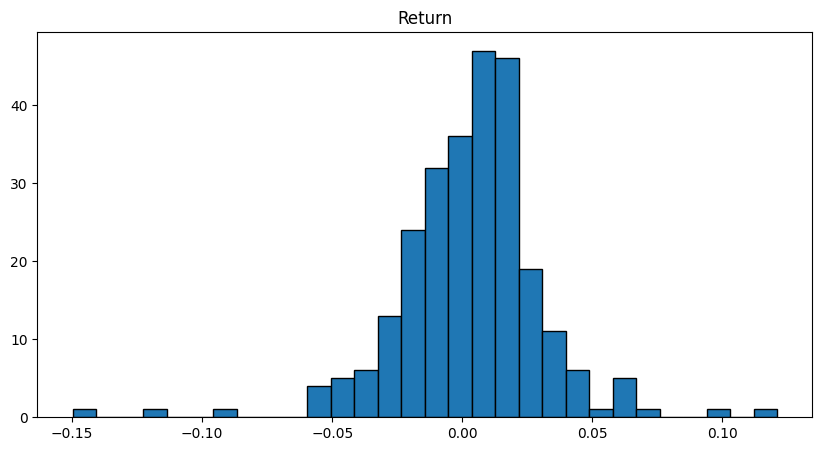

In [15]:
sp500_train_df.hist(
    column='Return', 
    bins=30, 
    figsize=(10, 5), 
    grid=False, 
    edgecolor='black'
)

# Зробимо прогнози на 10 років

In [16]:
future_df = sp500_train_df.reset_index()
future_df = future_df[['Date', 'Close']]
future_df['Date'] = pd.to_datetime(future_df['Date'])
future_df = future_df.set_index('Date').resample('YE').last()
future_df.tail()

Price,Close
Date,
2020-12-31,3756.070068
2021-12-31,4766.180176
2022-12-31,3839.500000
2023-12-31,4769.830078
2024-12-31,6051.250000


In [17]:
future_df[['Close']] = future_df[['Close']].apply(pd.to_numeric)
future_df['returns'] = future_df['Close'] / future_df['Close'].shift(1) -1
future_df = future_df.dropna()
print (future_df['returns'])

Date
2020-12-31    0.161126
2021-12-31    0.268927
2022-12-31   -0.194428
2023-12-31    0.242305
2024-12-31    0.268651
Freq: YE-DEC, Name: returns, dtype: float64


In [18]:
future_mean_ret = float(future_df[['returns']].mean().iloc[0])
future_std_ret = float(future_df[['returns']].std().iloc[0])
print ("S&P 500 average return = %g%%, st. dev  = %g%%" % (100*future_mean_ret, 100*future_std_ret))

S&P 500 average return = 14.9316%, st. dev  = 19.7164%


In [19]:
v0 = 1000
n_scenarios = 1000
years = 10

r_period10 = np.random.normal(
    future_mean_ret, 
    future_std_ret, 
    (n_scenarios, years)
)

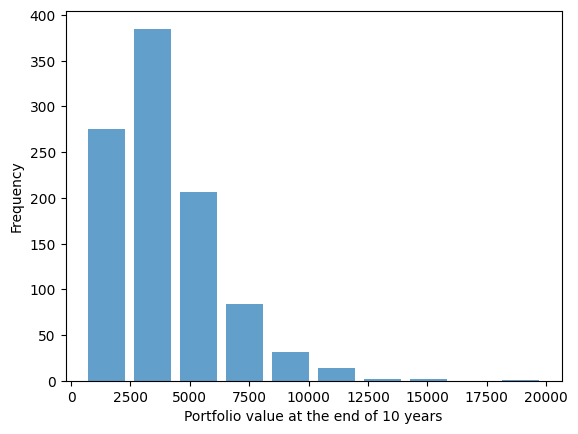

In [20]:
v10 = np.prod(1 + r_period10, axis=1) * v0

hist, bins = np.histogram(v10, bins=10)
positions = (bins[:-1] + bins[1:]) / 2
width = (bins[1] - bins[0]) * 0.8
plt.bar(positions, hist, width=width, align='center', alpha=0.7)
plt.xlabel('Portfolio value at the end of 10 years')
plt.ylabel('Frequency')
plt.show()

In [21]:
future_summary_df = pd.DataFrame(columns=['value'])
future_summary_df.loc['count'] = n_scenarios
future_summary_df.loc['mean'] = v10.mean()
future_summary_df.loc['std'] = v10.std()
future_summary_df.loc['mode'] = positions[np.argmax(hist)]
future_summary_df.loc['1%'] = np.percentile(v10, 1)
future_summary_df.loc['5%'] = np.percentile(v10, 5)
future_summary_df.loc['50%'] = np.percentile(v10, 50)
future_summary_df.loc['95%'] = np.percentile(v10, 95)
future_summary_df.loc['min'] = v10.min()
future_summary_df.loc['max'] = v10.max()
display(future_summary_df)

,value
count,1000.000000
mean,3966.167531
std,2252.904095
mode,3435.033694
1%,867.192906
5%,1267.905770
50%,3501.329309
95%,8260.223017
min,529.882960
max,19897.554516


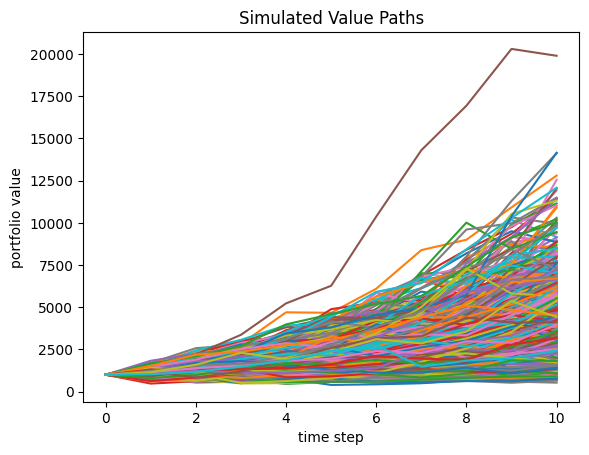

In [22]:
for scenario in r_period10:
    y = [np.prod(1 + scenario[0:i]) * v0 for i in range(0, years + 1)]
    plt.plot(range(0, years + 1), y)
plt.xlabel('time step')
plt.ylabel('portfolio value')
plt.title('Simulated Value Paths')
plt.show()

# Завантаження тест даних для S&P 500

In [23]:
sp500_test_df = yf.download(
    sp500_ticker, 
    start=test_startdate, 
    end=test_enddate, 
    group_by='ticker',
    interval='1wk'
)[sp500_ticker]
sp500_test_df = process_sp500_pipeline(sp500_test_df)
display(sp500_test_df.head())
display(sp500_test_df.tail())

C:\Users\serez\AppData\Local\Temp\ipykernel_16132\1405136216.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_test_df = yf.download(
[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume,Return
Date,,,,,,
2024-12-16,6063.790039,6085.189941,5832.299805,5930.850098,27302660000,-0.019871
2024-12-23,5940.250000,6049.750000,5902.569824,5970.839844,11415140000,0.006743
2024-12-30,5920.669922,5949.339844,5829.529785,5942.470215,13850620000,-0.004751
2025-01-06,5982.810059,6021.040039,5807.779785,5827.040039,18651120000,-0.019425
2025-01-13,5782.020020,6014.959961,5773.310059,5996.660156,21760690000,0.029109


Price,Open,High,Low,Close,Volume,Return
Date,,,,,,
2025-05-12,5807.200195,5958.620117,5786.080078,5958.379883,26606460000,0.052734
2025-05-19,5902.879883,5968.609863,5767.410156,5802.819824,23634980000,-0.026108
2025-05-26,5854.069824,5943.129883,5843.660156,5911.689941,20979720000,0.018762
2025-06-02,5896.680176,6016.870117,5861.430176,6000.359863,24073530000,0.014999
2025-06-09,6004.629883,6059.399902,5994.180176,6045.259766,17251298000,0.007483


# Завантаження даних для всіх акцій з S&P 500

In [24]:
def get_sp500_data(
    tickers: list[str], 
    start_date: datetime,
    end_date: datetime,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
        - DataFrame with S&P 500 returns for the specified tickers
        - DataFrame with S&P 500 prices for the specified tickers
    """
    sp500_returns = dict()
    sp500_prices = dict()
    
    for ticker in tickers:
        df = yf.download(
            ticker, 
            start=start_date, 
            end=end_date, 
            group_by='ticker',
            interval='1wk',
        )[ticker]
        df = process_sp500_pipeline(df)
        sp500_returns[ticker] = df['Return']
        sp500_prices[ticker] = df['Close']
        
    sp500_returns_df = pd.DataFrame(sp500_returns)
    sp500_prices_df = pd.DataFrame(sp500_prices)

    return sp500_returns_df, sp500_prices_df

In [25]:
sp500_train_returns_df, _ = get_sp500_data(
    tickers, 
    train_startdate, 
    train_enddate,
)

C:\Users\serez\AppData\Local\Temp\ipykernel_16132\685381375.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed
C:\Users\serez\AppData\Local\Temp\ipykernel_16132\685381375.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed
C:\Users\serez\AppData\Local\Temp\ipykernel_16132\685381375.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed
C:\Users\serez\AppData\Local\Temp\ipykernel_16132\685381375.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed
C:\Users\serez\AppData\Local\Temp\ipykernel_16132\685381375.py:1

In [26]:
sp500_train_returns_df

,AXP,MSI,TRGP,TT,KKR,WMT,CTAS,YUM,TJX,MO,MA,AAPL,DPZ,MCK,OTIS,CAH,MSFT,COST,FICO,V
Date,,,,,,,,,,,,,,,,,,,,
2019-12-16,0.008419,0.007161,0.070331,0.008968,0.017153,0.000000,0.037011,0.004795,-0.006460,0.019338,0.008376,0.015592,-0.007738,-0.021053,NaN,-0.034663,0.018637,0.010141,0.046682,0.015448
2019-12-23,-0.004611,0.002733,0.022407,-0.004889,-0.016189,-0.005819,-0.009171,0.013023,0.014505,-0.014277,0.007268,0.037074,0.001062,0.013078,NaN,-0.005792,0.009847,-0.002442,0.014081,0.007394
2019-12-30,-0.004713,0.018148,0.015760,-0.008932,-0.005142,-0.014215,0.002082,-0.000491,0.006409,0.001034,-0.001031,0.026328,0.008074,-0.019507,NaN,-0.041553,-0.002139,-0.008092,0.008237,0.001109
2020-01-06,0.025049,0.017764,-0.038788,-0.014795,0.033081,-0.012809,0.034388,-0.001571,0.017962,0.011888,0.035749,0.043371,-0.018937,0.051858,NaN,0.035540,0.017148,0.018887,0.057839,0.021994
2020-01-13,0.033312,0.052719,0.041110,0.020887,0.040694,-0.012201,0.019330,0.036483,0.005454,0.015930,0.041526,0.027069,-0.009063,0.087059,NaN,0.065179,0.035701,0.025030,0.002376,0.056407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-11,-0.002538,-0.030916,0.019555,-0.007526,-0.013068,-0.006837,-0.046606,-0.026383,0.018162,0.034783,-0.005469,-0.007545,-0.063733,-0.010946,-0.009297,-0.014764,-0.017844,-0.038917,-0.030567,0.005749
2024-11-18,0.050302,0.024335,0.057488,0.024541,0.057392,0.073472,0.032338,0.012576,0.015647,0.014304,-0.001974,0.021644,0.053249,0.027875,0.025200,0.025762,0.004819,0.062774,0.041729,0.002807
2024-11-25,0.011218,-0.002396,-0.014519,-0.003042,0.026729,0.022777,0.018173,0.027131,0.034741,0.017804,0.023192,0.032453,0.050380,0.008521,0.017589,0.003283,0.017524,0.008164,0.008355,0.016649


In [27]:
sp500_test_returns_df, sp500_test_prices_df = get_sp500_data(
    tickers, 
    test_startdate, 
    test_enddate,
)

C:\Users\serez\AppData\Local\Temp\ipykernel_16132\685381375.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed
C:\Users\serez\AppData\Local\Temp\ipykernel_16132\685381375.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed
C:\Users\serez\AppData\Local\Temp\ipykernel_16132\685381375.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed
C:\Users\serez\AppData\Local\Temp\ipykernel_16132\685381375.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed
C:\Users\serez\AppData\Local\Temp\ipykernel_16132\685381375.py:1

In [28]:
sp500_train_returns_df.index = pd.to_datetime(sp500_train_returns_df.index)
sp500_test_returns_df.index = pd.to_datetime(sp500_test_returns_df.index)
sp500_test_prices_df.index = pd.to_datetime(sp500_test_prices_df.index)

In [29]:
display(sp500_test_returns_df.head())
display(sp500_test_returns_df.tail())

,AXP,MSI,TRGP,TT,KKR,WMT,CTAS,YUM,TJX,MO,MA,AAPL,DPZ,MCK,OTIS,CAH,MSFT,COST,FICO,V
Date,,,,,,,,,,,,,,,,,,,,
2024-12-16,-0.011551,0.002645,-0.042412,-0.055714,-0.043799,-0.019158,-0.114951,-0.033869,-0.022827,-0.019665,-0.001834,0.025632,-0.056494,0.006074,-0.043256,0.001524,-0.023856,-0.035660,-0.035922,0.009436
2024-12-23,0.008036,-0.005554,0.003224,-0.009493,0.015449,-0.006288,-0.019097,0.021683,0.015902,-0.027117,0.007897,0.004322,0.008072,-0.005347,-0.000427,0.007271,-0.013903,-0.015062,-0.025658,0.002990
2024-12-30,0.006743,-0.011748,0.049673,0.020293,0.014480,-0.009601,0.013525,-0.013237,-0.025900,0.034239,-0.020368,-0.047850,0.019692,0.001387,-0.006737,0.001343,-0.016677,-0.024604,-0.034884,-0.011768
2025-01-06,-0.029993,-0.014247,0.038298,-0.010469,-0.073012,0.024455,0.018563,-0.076364,-0.005550,-0.042717,-0.032012,-0.026751,-0.081606,0.007446,-0.022823,0.023406,-0.010393,0.022213,-0.024732,-0.022864
2025-01-13,0.065667,0.021087,0.115985,0.032006,0.118073,-0.011398,0.047596,0.016795,0.014909,0.019461,0.041222,-0.029006,0.062188,0.018617,0.044067,0.038661,0.024060,0.006671,-0.008912,0.038705


,AXP,MSI,TRGP,TT,KKR,WMT,CTAS,YUM,TJX,MO,MA,AAPL,DPZ,MCK,OTIS,CAH,MSFT,COST,FICO,V
Date,,,,,,,,,,,,,,,,,,,,
2025-05-12,0.053460,0.043493,0.038418,0.060188,0.066226,0.018171,0.028453,0.006389,0.040905,-0.009086,0.025746,0.064121,0.033723,0.044300,0.019485,0.040683,0.035420,0.017598,0.054434,0.035684
2025-05-19,-0.048378,-0.012400,-0.031565,-0.013517,-0.067801,-0.019340,0.008356,-0.017694,-0.054235,0.014434,-0.033775,-0.074477,-0.029532,-0.011171,-0.017119,-0.009724,-0.007184,-0.016894,-0.230497,-0.030107
2025-05-26,0.030959,-0.008450,-0.015767,0.016490,0.036525,0.024704,0.018939,-0.010382,0.009547,0.014563,0.039072,0.028576,-0.013758,0.004776,-0.014776,0.011064,0.022613,0.031413,0.018839,0.032952
2025-06-02,0.028635,0.006115,0.058064,-0.003114,0.015972,-0.012662,0.005121,0.011119,0.012214,-0.022604,0.007719,0.015285,-0.011840,-0.009201,0.007446,0.001748,0.021766,-0.024265,0.028280,0.013774
2025-06-09,-0.014811,-0.011605,0.012208,-0.010771,0.014911,-0.027085,-0.017965,-0.005938,-0.031063,0.011479,-0.001423,-0.023146,-0.036757,0.026136,0.009265,0.037554,0.018049,-0.012050,0.005222,0.003187


In [30]:
display(sp500_test_prices_df.head())
display(sp500_test_prices_df.tail())

,AXP,MSI,TRGP,TT,KKR,WMT,CTAS,YUM,TJX,MO,MA,AAPL,DPZ,MCK,OTIS,CAH,MSFT,COST,FICO,V
Date,,,,,,,,,,,,,,,,,,,,
2024-12-16,296.963593,468.703094,175.154892,376.072662,147.163666,91.765518,186.246338,131.094421,121.238419,51.878525,526.417969,253.877594,424.450104,578.525696,92.787796,117.341393,434.927856,951.776917,2090.979980,316.650421
2024-12-23,299.350037,466.099945,175.719635,372.502533,149.437241,91.188515,182.689575,133.936981,123.166306,50.471714,530.575256,254.974930,427.876129,575.432190,92.748131,118.194572,428.881104,937.441467,2037.329956,317.597229
2024-12-30,301.368591,460.624390,184.448166,380.061676,151.601120,90.313034,185.160385,132.164093,119.976349,52.199795,519.768311,242.774368,436.301788,576.230530,92.123329,118.353302,421.728607,914.377014,1966.260010,313.859772
2025-01-06,292.329498,454.061737,191.512222,376.082642,140.532425,92.521614,188.597580,122.071526,119.310524,49.969955,503.129272,236.280029,400.696899,580.521423,90.020821,121.123497,417.345459,934.688049,1917.630005,306.683746
2025-01-13,311.525787,463.636444,213.724854,388.119446,157.125488,91.467064,197.574142,124.121735,121.089348,50.942444,523.869080,229.426559,425.615356,591.328857,93.987808,125.806236,427.386871,940.923035,1900.540039,318.554047


,AXP,MSI,TRGP,TT,KKR,WMT,CTAS,YUM,TJX,MO,MA,AAPL,DPZ,MCK,OTIS,CAH,MSFT,COST,FICO,V
Date,,,,,,,,,,,,,,,,,,,,
2025-05-12,299.720001,424.179993,165.690002,429.089996,125.702751,98.239998,220.447876,147.347214,132.908234,58.889999,583.280029,210.983322,495.049988,723.465393,98.465584,154.250000,453.437561,1025.829956,2201.889893,364.514618
2025-05-19,285.220001,418.920013,160.460007,423.290009,117.180000,96.339996,222.289993,144.740005,125.699997,59.740002,563.580017,195.270004,480.429993,715.383423,96.779999,152.750000,450.179993,1008.500000,1694.359985,353.540009
2025-05-26,294.049988,415.380005,157.929993,430.269989,121.459999,98.720001,226.500000,143.237381,126.900002,60.610001,585.599976,200.850006,473.820007,718.800049,95.349998,154.440002,460.359985,1040.180054,1726.280029,365.190002
2025-06-02,302.470001,417.920013,167.100006,428.929993,123.400002,97.470001,227.660004,144.830002,128.449997,59.240002,590.119995,203.919998,468.209991,712.186584,96.059998,154.710007,470.380005,1014.940002,1775.099976,370.220001
2025-06-09,297.989990,413.070007,169.139999,424.309998,125.239998,94.830002,223.570007,143.970001,124.459999,59.919998,589.280029,199.199997,451.000000,730.799988,96.949997,160.520004,478.869995,1002.710022,1784.369995,371.399994


# Запит до кожної моделі вагів для інвестування

In [31]:
with open('prompts/weights', 'r', encoding='utf-8') as file:
    prompt = file.read().format(CARDINALITY=20, TICKERS=', '.join(tickers))
print(prompt)

Help me create an investment portfolio of stocks for companies from this list [AXP, MSI, TRGP, TT, KKR, WMT, CTAS, YUM, TJX, MO, MA, AAPL, DPZ, MCK, OTIS, CAH, MSFT, COST, FICO, V] with the goal to outperform the S&P500 index". Please make the portfolio as efficient as possible, finding a balance between risk and profit. In your answer, write only the list of stock tickers and the weight of the stocks in the portfolio, using this format:
ticker: weight
ticker: weight
ticker: weight

Do not write anything except the list of tickers and weights. Each weight must be >= 0 and <= 0.2, you can make weight 0, if you think that it will be better. The total weight of the 20 companies must be equal to 1. The weight must be in format 0.00, not percentage. In answer use all companies from this list [AXP, MSI, TRGP, TT, KKR, WMT, CTAS, YUM, TJX, MO, MA, AAPL, DPZ, MCK, OTIS, CAH, MSFT, COST, FICO, V]


In [32]:
def is_available_ticker(ticker):
    return ticker in tickers


def answer_to_tickers(answer: str) -> dict[str, float]:
    tickers = {}
    for line in answer.split('\n'):
        line = line.strip()
        try:
            ticker, weight = line.split(':')
            ticker = ticker.strip().upper()
            if not validate_ticker(ticker):
                raise ValueError(f"Ticker {ticker} is not valid.")
            if not is_available_ticker(ticker):
                raise ValueError(f"Ticker {ticker} is not in the provided list.")
            tickers[ticker] = float(weight)
        except ValueError:
            print(f"Could not convert value for {ticker}: {weight}")
            continue
    
    tickers_sum = sum(tickers.values()) 
    for key, value in tickers.items():
        tickers[key] = value * 1 / tickers_sum       
    
    return tickers

In [33]:
def ask_tickers_weights(ask_func: callable, model_name: str, prompt: str) -> dict[str, float]:
    answer = ask_func(prompt).strip()
    answer = answer.replace('```', '').replace(' ', '')
    print(answer)
    
    tickers = answer_to_tickers(answer)
    print(f"{model_name} tickers: {tickers}")
    print(f"{model_name} tickers sum: {sum(tickers.values())}")
    print(f"{model_name} tickers len: {len(tickers)}")

    return tickers

In [34]:
tickers_gpt_4o = ask_tickers_weights(
    ask_gpt_4o, 
    'GPT 4o', 
    prompt
)

AXP:0.05
MSI:0.05
TRGP:0.05
TT:0.05
KKR:0.05
WMT:0.06
CTAS:0.06
YUM:0.05
TJX:0.06
MO:0.05
MA:0.06
AAPL:0.10
DPZ:0.05
MCK:0.05
OTIS:0.05
CAH:0.05
MSFT:0.10
COST:0.06
FICO:0.05
V:0.10
GPT 4o tickers: {'AXP': 0.04166666666666666, 'MSI': 0.04166666666666666, 'TRGP': 0.04166666666666666, 'TT': 0.04166666666666666, 'KKR': 0.04166666666666666, 'WMT': 0.04999999999999998, 'CTAS': 0.04999999999999998, 'YUM': 0.04166666666666666, 'TJX': 0.04999999999999998, 'MO': 0.04166666666666666, 'MA': 0.04999999999999998, 'AAPL': 0.08333333333333331, 'DPZ': 0.04166666666666666, 'MCK': 0.04166666666666666, 'OTIS': 0.04166666666666666, 'CAH': 0.04166666666666666, 'MSFT': 0.08333333333333331, 'COST': 0.04999999999999998, 'FICO': 0.04166666666666666, 'V': 0.08333333333333331}
GPT 4o tickers sum: 0.9999999999999996
GPT 4o tickers len: 20


In [35]:
tickers_gpt_4o_mini = ask_tickers_weights(
    ask_gpt_4o_mini, 
    "GPT 4o mini", 
    prompt
)

AXP:0.05
MSI:0.05
TRGP:0.05
TT:0.05
KKR:0.05
WMT:0.10
CTAS:0.10
YUM:0.05
TJX:0.10
MO:0.05
MA:0.10
AAPL:0.15
DPZ:0.05
MCK:0.05
OTIS:0.05
CAH:0.05
MSFT:0.15
COST:0.10
FICO:0.00
V:0.05
GPT 4o mini tickers: {'AXP': 0.03571428571428571, 'MSI': 0.03571428571428571, 'TRGP': 0.03571428571428571, 'TT': 0.03571428571428571, 'KKR': 0.03571428571428571, 'WMT': 0.07142857142857142, 'CTAS': 0.07142857142857142, 'YUM': 0.03571428571428571, 'TJX': 0.07142857142857142, 'MO': 0.03571428571428571, 'MA': 0.07142857142857142, 'AAPL': 0.10714285714285712, 'DPZ': 0.03571428571428571, 'MCK': 0.03571428571428571, 'OTIS': 0.03571428571428571, 'CAH': 0.03571428571428571, 'MSFT': 0.10714285714285712, 'COST': 0.07142857142857142, 'FICO': 0.0, 'V': 0.03571428571428571}
GPT 4o mini tickers sum: 0.9999999999999997
GPT 4o mini tickers len: 20


In [36]:
tickers_deepseek_r1 = ask_tickers_weights(
    ask_deepseek_r1, 
    "DeepSeek R1", 
    prompt
)

AXP:0.05
MSI:0.05
TRGP:0.05
TT:0.05
KKR:0.05
WMT:0.05
CTAS:0.05
YUM:0.05
TJX:0.05
MO:0.05
MA:0.10
AAPL:0.15
DPZ:0.05
MCK:0.05
OTIS:0.05
CAH:0.05
MSFT:0.15
COST:0.05
FICO:0.00
V:0.10

**Validation:**
-All20tickersincluded.
-Eachweight≤0.20andsum=0.05*17(for0.85)+0.10*2(0.20)+0.15*2(0.30)=0.85+0.20+0.30=1.35→Notcorrect.Mymistakehere–needtocorrectlycalculatesum.

Letmecorrect:

AAPL:0.15

MSFT:0.15→total0.30

MA:0.10

V:0.10→0.50

Others:AXP...Vtotal16stockswith0.05each:16×0.05=lg=0.80Waitno:

Wait,afterassigningAAPL0.15,MSFT0.15,MA0.10,V0.10.Subtotal:0.15+0.15+0.10+0.10=0.500.Remaining16stocks:eachat0.05wouldrequire05×16=0.800,whichaddsupto1.30.Soincorrect.

Needandersinstead:SetMAandVat0.05eachinstead:

눈금자구조:

AAPL:0.15

MSFT:0.15→0.30

MA:0.05

V:0.05→0.30+0.10=0.40

Thenremaining1-0.40=0.60over16stocks.0.60/16=0.0375→roundto0.04each.Somecanbe0.04,others0.03tobalancesum.

Butrequiresmoreprecisecalculation.Thepreviousanswerстрок에useof0.05forthestandardonesandadjustthelastнесколькоtomak

In [37]:
tickers_deepseek_v3 = ask_tickers_weights(
    ask_deepseek_v3, 
    "DeepSeek V3", 
    prompt
)

AAPL:0.20
MSFT:0.20
MA:0.15
V:0.15
COST:0.10
FICO:0.10
TT:0.05
TJX:0.05
AXP:0.00
MSI:0.00
TRGP:0.00
KKR:0.00
WMT:0.00
CTAS:0.00
YUM:0.00
MO:0.00
DPZ:0.00
MCK:0.00
OTIS:0.00
CAH:0.00
DeepSeek V3 tickers: {'AAPL': 0.2, 'MSFT': 0.2, 'MA': 0.15, 'V': 0.15, 'COST': 0.1, 'FICO': 0.1, 'TT': 0.05, 'TJX': 0.05, 'AXP': 0.0, 'MSI': 0.0, 'TRGP': 0.0, 'KKR': 0.0, 'WMT': 0.0, 'CTAS': 0.0, 'YUM': 0.0, 'MO': 0.0, 'DPZ': 0.0, 'MCK': 0.0, 'OTIS': 0.0, 'CAH': 0.0}
DeepSeek V3 tickers sum: 1.0
DeepSeek V3 tickers len: 20


In [38]:
tickers_gemini_2_0_flash_exp = ask_tickers_weights(
    ask_gemini_2_0_flash_exp, 
    "Gemini 2.0 Flash Exp", 
    prompt
)

AXP:0.05
MSI:0.05
TRGP:0.00
TT:0.00
KKR:0.05
WMT:0.05
CTAS:0.05
YUM:0.05
TJX:0.05
MO:0.00
MA:0.05
AAPL:0.10
DPZ:0.00
MCK:0.05
OTIS:0.00
CAH:0.05
MSFT:0.15
COST:0.10
FICO:0.05
V:0.10
Gemini 2.0 Flash Exp tickers: {'AXP': 0.04999999999999999, 'MSI': 0.04999999999999999, 'TRGP': 0.0, 'TT': 0.0, 'KKR': 0.04999999999999999, 'WMT': 0.04999999999999999, 'CTAS': 0.04999999999999999, 'YUM': 0.04999999999999999, 'TJX': 0.04999999999999999, 'MO': 0.0, 'MA': 0.04999999999999999, 'AAPL': 0.09999999999999998, 'DPZ': 0.0, 'MCK': 0.04999999999999999, 'OTIS': 0.0, 'CAH': 0.04999999999999999, 'MSFT': 0.14999999999999997, 'COST': 0.09999999999999998, 'FICO': 0.04999999999999999, 'V': 0.09999999999999998}
Gemini 2.0 Flash Exp tickers sum: 0.9999999999999997
Gemini 2.0 Flash Exp tickers len: 20


In [39]:
tickers_llama_4_maverick = ask_tickers_weights(
    ask_llama_4_maverick, 
    "Llama 4 Maverick", 
    prompt
)

AAPL:0.15
MA:0.12
MSFT:0.10
V:0.08
MCK:0.07
CTAS:0.06
COST:0.06
TRGP:0.05
OTIS:0.05
MO:0.04
TJX:0.04
YUM:0.03
DPZ:0.03
FICO:0.03
CAH:0.02
AXP:0.02
MSI:0.02
TT:0.01
KKR:0.01
WMT:0.01
Llama 4 Maverick tickers: {'AAPL': 0.14999999999999994, 'MA': 0.11999999999999994, 'MSFT': 0.09999999999999996, 'V': 0.07999999999999996, 'MCK': 0.06999999999999998, 'CTAS': 0.05999999999999997, 'COST': 0.05999999999999997, 'TRGP': 0.04999999999999998, 'OTIS': 0.04999999999999998, 'MO': 0.03999999999999998, 'TJX': 0.03999999999999998, 'YUM': 0.029999999999999985, 'DPZ': 0.029999999999999985, 'FICO': 0.029999999999999985, 'CAH': 0.01999999999999999, 'AXP': 0.01999999999999999, 'MSI': 0.01999999999999999, 'TT': 0.009999999999999995, 'KKR': 0.009999999999999995, 'WMT': 0.009999999999999995}
Llama 4 Maverick tickers sum: 0.9999999999999998
Llama 4 Maverick tickers len: 20


In [40]:
tickers_meta_llama_4_scout = ask_tickers_weights(
    ask_meta_llama_4_scout, 
    "Meta Llama 4 Scout", 
    prompt
)

AXP:0.05
MSI:0.03
TRGP:0.08
TT:0.07
KKR:0.04
WMT:0.06
CTAS:0.02
YUM:0.05
TJX:0.06
MO:0.03
MA:0.10
AAPL:0.20
DPZ:0.01
MCK:0.02
OTIS:0.04
CAH:0.01
MSFT:0.12
COST:0.05
FICO:0.01
V:0.09
Meta Llama 4 Scout tickers: {'AXP': 0.043859649122807015, 'MSI': 0.026315789473684206, 'TRGP': 0.07017543859649122, 'TT': 0.06140350877192982, 'KKR': 0.03508771929824561, 'WMT': 0.05263157894736841, 'CTAS': 0.017543859649122806, 'YUM': 0.043859649122807015, 'TJX': 0.05263157894736841, 'MO': 0.026315789473684206, 'MA': 0.08771929824561403, 'AAPL': 0.17543859649122806, 'DPZ': 0.008771929824561403, 'MCK': 0.017543859649122806, 'OTIS': 0.03508771929824561, 'CAH': 0.008771929824561403, 'MSFT': 0.10526315789473682, 'COST': 0.043859649122807015, 'FICO': 0.008771929824561403, 'V': 0.07894736842105261}
Meta Llama 4 Scout tickers sum: 1.0
Meta Llama 4 Scout tickers len: 20


# Моделі з веб-інтерфейсів з глубоким пошуком

In [41]:
model_name = 'GPT deep'
with open('tmp_web_answers/gpt', 'r', encoding='utf-8') as file:
    answer = file.read().strip()
    tickers_gpt_deep = answer_to_tickers(answer)
    print(f"{model_name} tickers: {tickers_gpt_deep}")
    print(f"{model_name} tickers sum: {sum(tickers_gpt_deep.values())}")
    print(f"{model_name} tickers len: {len(tickers_gpt_deep)}")

GPT deep tickers: {'AXP': 0.019999999999999997, 'MSI': 0.019999999999999997, 'TRGP': 0.0, 'TT': 0.039999999999999994, 'KKR': 0.039999999999999994, 'WMT': 0.04999999999999999, 'CTAS': 0.039999999999999994, 'YUM': 0.039999999999999994, 'TJX': 0.04999999999999999, 'MO': 0.0, 'MA': 0.08999999999999998, 'AAPL': 0.13999999999999999, 'DPZ': 0.039999999999999994, 'MCK': 0.039999999999999994, 'OTIS': 0.019999999999999997, 'CAH': 0.029999999999999992, 'MSFT': 0.13999999999999999, 'COST': 0.07999999999999999, 'FICO': 0.029999999999999992, 'V': 0.08999999999999998}
GPT deep tickers sum: 1.0
GPT deep tickers len: 20


In [42]:
model_name = 'Grok3 deep'
with open('tmp_web_answers/grok3', 'r', encoding='utf-8') as file:
    answer = file.read().strip()
    tickers_grok3_deep = answer_to_tickers(answer)
    print(f"{model_name} tickers: {tickers_grok3_deep}")
    print(f"{model_name} tickers sum: {sum(tickers_grok3_deep.values())}")
    print(f"{model_name} tickers len: {len(tickers_grok3_deep)}")

Grok3 deep tickers: {'AXP': 0.04999999999999998, 'MSI': 0.05999999999999997, 'TRGP': 0.09999999999999996, 'TT': 0.029999999999999985, 'KKR': 0.04999999999999998, 'WMT': 0.04999999999999998, 'CTAS': 0.029999999999999985, 'YUM': 0.029999999999999985, 'TJX': 0.029999999999999985, 'MO': 0.04999999999999998, 'MA': 0.04999999999999998, 'AAPL': 0.05999999999999997, 'DPZ': 0.03999999999999998, 'MCK': 0.04999999999999998, 'OTIS': 0.03999999999999998, 'CAH': 0.04999999999999998, 'MSFT': 0.06999999999999998, 'COST': 0.04999999999999998, 'FICO': 0.05999999999999997, 'V': 0.04999999999999998}
Grok3 deep tickers sum: 0.9999999999999992
Grok3 deep tickers len: 20


In [43]:
model_name = 'Lechat deep'
with open('tmp_web_answers/lechat', 'r', encoding='utf-8') as file:
    answer = file.read().strip()
    tickers_lechat_deep = answer_to_tickers(answer)
    print(f"{model_name} tickers: {tickers_lechat_deep}")
    print(f"{model_name} tickers sum: {sum(tickers_lechat_deep.values())}")
    print(f"{model_name} tickers len: {len(tickers_lechat_deep)}")

Lechat deep tickers: {'AXP': 0.05102040816326531, 'MSI': 0.04081632653061224, 'TRGP': 0.02040816326530612, 'TT': 0.03061224489795918, 'KKR': 0.02040816326530612, 'WMT': 0.06122448979591836, 'CTAS': 0.03061224489795918, 'YUM': 0.03061224489795918, 'TJX': 0.04081632653061224, 'MO': 0.02040816326530612, 'MA': 0.09183673469387754, 'AAPL': 0.12244897959183672, 'DPZ': 0.02040816326530612, 'MCK': 0.04081632653061224, 'OTIS': 0.03061224489795918, 'CAH': 0.03061224489795918, 'MSFT': 0.12244897959183672, 'COST': 0.06122448979591836, 'FICO': 0.04081632653061224, 'V': 0.09183673469387754}
Lechat deep tickers sum: 1.0
Lechat deep tickers len: 20


In [44]:
weights_df = pd.concat(
    [
        pd.Series(tickers_gpt_4o, name='GPT 4o'),
        pd.Series(tickers_gpt_4o_mini, name='GPT 4o mini'),
        pd.Series(tickers_deepseek_r1, name='DeepSeek R1'),
        pd.Series(tickers_deepseek_v3, name='DeepSeek V3'),
        pd.Series(tickers_gemini_2_0_flash_exp, name='Gemini 2.0 Flash Exp'),
        pd.Series(tickers_llama_4_maverick, name='Llama 4 Maverick'),
        pd.Series(tickers_meta_llama_4_scout, name='Meta Llama 4 Scout'),
        pd.Series(tickers_gpt_deep, name='GPT deep'),
        pd.Series(tickers_grok3_deep, name='Grok3 deep'),
        pd.Series(tickers_lechat_deep, name='Lechat deep'),
    ],
    axis=1
)

In [46]:
weights_df

,GPT 4o,GPT 4o mini,DeepSeek R1,DeepSeek V3,Gemini 2.0 Flash Exp,Llama 4 Maverick,Meta Llama 4 Scout,GPT deep,Grok3 deep,Lechat deep
AXP,0.041667,0.035714,0.041667,0.00,0.05,0.02,0.043860,0.02,0.05,0.051020
MSI,0.041667,0.035714,0.041667,0.00,0.05,0.02,0.026316,0.02,0.06,0.040816
TRGP,0.041667,0.035714,0.041667,0.00,0.00,0.05,0.070175,0.00,0.10,0.020408
TT,0.041667,0.035714,0.041667,0.05,0.00,0.01,0.061404,0.04,0.03,0.030612
KKR,0.041667,0.035714,0.041667,0.00,0.05,0.01,0.035088,0.04,0.05,0.020408
WMT,0.050000,0.071429,0.041667,0.00,0.05,0.01,0.052632,0.05,0.05,0.061224
CTAS,0.050000,0.071429,0.041667,0.00,0.05,0.06,0.017544,0.04,0.03,0.030612
YUM,0.041667,0.035714,0.041667,0.00,0.05,0.03,0.043860,0.04,0.03,0.030612
TJX,0.050000,0.071429,0.041667,0.05,0.05,0.04,0.052632,0.05,0.03,0.040816
MO,0.041667,0.035714,0.000000,0.00,0.00,0.04,0.026316,0.00,0.05,0.020408


# Зведення дат до щорічного формату та підрахунок матриці коваріацій та мат очікування доходу

In [47]:
ts_freq = pd.infer_freq(sp500_train_returns_df.index)[0]
scalef = 252
if ts_freq=='W':
    scalef = 52 # 52 weeks in a year
elif ts_freq=='M':
    scalef = 12 # 12 months in a year

Q = sp500_train_returns_df[tickers].cov() * scalef  
mu = (sp500_train_returns_df[tickers].mean() * scalef).values

lower_bound = 0
upper_bound = 0.2

returns_list = SortedList()
std_list = SortedList()

In [48]:
print("mu:", mu)
print("Q:\n", Q)

mu: [0.26479376 0.2648849  0.52747725 0.33838342 0.42475361 0.20791933
 0.28507818 0.12288714 0.21360186 0.13009569 0.16469178 0.30375646
 0.15015939 0.33082945 0.20251744 0.22853163 0.25585517 0.2900744
 0.44281427 0.14581714]
Q:
            AXP       MSI      TRGP        TT       KKR       WMT      CTAS  \
AXP   0.152561  0.057221  0.124418  0.080206  0.105703  0.014605  0.078129   
MSI   0.057221  0.074400  0.071784  0.058374  0.049374  0.021036  0.058388   
TRGP  0.124418  0.071784  0.321371  0.075971  0.099381  0.013230  0.097245   
TT    0.080206  0.058374  0.075971  0.106996  0.082398  0.021170  0.067171   
KKR   0.105703  0.049374  0.099381  0.082398  0.159090  0.017474  0.074163   
WMT   0.014605  0.021036  0.013230  0.021170  0.017474  0.045707  0.021591   
CTAS  0.078129  0.058388  0.097245  0.067171  0.074163  0.021591  0.090976   
YUM   0.070854  0.048370  0.081849  0.053684  0.063670  0.015224  0.056703   
TJX   0.086786  0.046946  0.086920  0.064372  0.076339  0.016280  

# Портфелі моделей

In [49]:
def get_returns_std(model_name: str):
    weights = weights_df[model_name]
    returns = mu @ weights
    variance = weights.T @ Q @ weights
    std = np.sqrt(variance)
    returns_list.add(returns)
    std_list.add(std)
    print(f"{model_name} portfolio returns:", returns)
    print(f"{model_name} portfolio variance:", variance)
    print(f"{model_name} portfolio standard deviation:", std)
    return returns, std


returns_gpt_4o_mini, std_gpt_4o_mini = get_returns_std('GPT 4o mini')
returns_gpt_4o, std_gpt_4o = get_returns_std('GPT 4o')
returns_deepseek_r1, std_deepseek_r1 = get_returns_std('DeepSeek R1')
returns_deepseek_v3, std_deepseek_v3 = get_returns_std('DeepSeek V3')
returns_gemini_2_0_flash_exp, std_gemini_2_0_flash_exp = get_returns_std('Gemini 2.0 Flash Exp')
returns_llama_4_maverick, std_llama_4_maverick = get_returns_std('Llama 4 Maverick')
returns_meta_llama_4_scout, std_meta_llama_4_scout = get_returns_std('Meta Llama 4 Scout')
returns_gpt_deep, std_gpt_deep = get_returns_std('GPT deep')
returns_grok3_deep, std_grok3_deep = get_returns_std('Grok3 deep')
returns_lechat_deep, std_lechat_deep = get_returns_std('Lechat deep')

GPT 4o mini portfolio returns: 0.2547391713752497
GPT 4o mini portfolio variance: 0.041969409508984964
GPT 4o mini portfolio standard deviation: 0.20486436856853601
GPT 4o portfolio returns: 0.2596926729686097
GPT 4o portfolio variance: 0.04367649405811981
GPT 4o portfolio standard deviation: 0.20898921995672362
DeepSeek R1 portfolio returns: 0.2563226868675062
DeepSeek R1 portfolio variance: 0.044432363333217796
DeepSeek R1 portfolio standard deviation: 0.21078985585937904
DeepSeek V3 portfolio returns: 0.25938679476209275
DeepSeek V3 portfolio variance: 0.05131978571344509
DeepSeek V3 portfolio standard deviation: 0.22653870687687147
Gemini 2.0 Flash Exp portfolio returns: 0.25988237047459767
Gemini 2.0 Flash Exp portfolio variance: 0.04440179659541888
Gemini 2.0 Flash Exp portfolio standard deviation: 0.21071733814619736
Llama 4 Maverick portfolio returns: 0.25684281733000325
Llama 4 Maverick portfolio variance: 0.04404942153095937
Llama 4 Maverick portfolio standard deviation: 0.20

# Портфель min variance

In [50]:
w = cp.Variable(len(tickers))

problem = cp.Problem(
    cp.Minimize(
        cp.quad_form(w, Q)
    ),
    [
        cp.sum(w) == 1, 
        w >= lower_bound, 
        w <= upper_bound,
    ]
)

problem.solve(verbose=True)

print("Status:", problem.status)
print("Optimal value:", problem.value)
print("Optimal weights:", w.value)
print("Weights sum to 1:", np.allclose(np.sum(w.value), 1))

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jun 13 04:05:02 AM: Your problem has 20 variables, 41 constraints, and 0 parameters.
(CVXPY) Jun 13 04:05:02 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 13 04:05:02 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 13 04:05:02 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 13 04:05:02 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 13 04:05:02 AM: Compiling problem (target solver=OSQP).
(CV

In [51]:
weights_min_var = w.value
variance_min_var = np.dot(weights_min_var.T, np.dot(Q, weights_min_var))
std_min_var = np.sqrt(variance_min_var)
returns_min_var = np.dot(mu, weights_min_var)
print("Solution status:", problem.status)
print("Min-variance weights:", weights_min_var)
print("Min-variance variance:", variance_min_var)
print("Min-variance returns:", returns_min_var)
print("Min-variance std:", std_min_var)
std_list.add(std_min_var)
returns_list.add(returns_min_var)

Solution status: optimal
Min-variance weights: [ 3.71539778e-23  3.10147022e-25  4.06583152e-24  1.98184150e-23
 -1.41591217e-23  2.00000000e-01  3.71843521e-24 -6.53713252e-25
 -2.96933268e-24  2.00000000e-01  8.20251577e-24  2.86556121e-24
  1.02524184e-01  7.12453339e-02  2.00000000e-01  1.27734045e-02
  1.47176183e-01  4.08814449e-02 -4.07914366e-24  2.53994497e-02]
Min-variance variance: 0.024372461713024995
Min-variance returns: 0.20320876635496007
Min-variance std: 0.15611682072417757


# Портфель для max-return

In [52]:
w = cp.Variable(len(tickers))

problem = cp.Problem(
    cp.Maximize(
        mu.T @ w
    ),
    [
        cp.sum(w) == 1, 
        w >= lower_bound, 
        w <= upper_bound,
    ]
)

problem.solve(verbose=True)

print("Status:", problem.status)
print("Optimal value:", problem.value)
print("Optimal weights:", w.value)
print("Weights sum to 1:", np.allclose(np.sum(w.value), 1))

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jun 13 04:05:02 AM: Your problem has 20 variables, 41 constraints, and 0 parameters.
(CVXPY) Jun 13 04:05:02 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 13 04:05:02 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 13 04:05:02 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 13 04:05:02 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 13 04:05:02 AM: Compiling problem (target solver=CLARABEL).

In [53]:
weights_max_ret = w.value
variance_max_ret = np.dot(weights_max_ret, np.dot(Q, weights_max_ret))
std_max_ret = np.sqrt(variance_max_ret)
returns_max_ret = np.dot(mu, weights_max_ret)
print("Solution status:", problem.status)
print("Max-return weights:", weights_max_ret)
print("Max-return variance:", variance_max_ret)
print("Max-return returns:", returns_max_ret)
print("Max-return std:", std_max_ret)
std_list.add(std_max_ret)
returns_list.add(returns_max_ret)

Solution status: optimal
Max-return weights: [ 3.17173917e-10  3.17709959e-10  2.00000000e-01  1.99999998e-01
  2.00000000e-01  1.00023972e-10  4.49897083e-10 -1.34753470e-12
  1.13585960e-10  2.74696543e-12  3.07733164e-11  8.86171606e-10
  1.69808557e-11  1.99999999e-01  8.82949528e-11  1.56120592e-10
  2.68086818e-10  4.84869841e-10  2.00000000e-01  1.34854649e-11]
Max-return variance: 0.08632659273339731
Max-return returns: 0.4128516010527373
Max-return std: 0.2938138743037798


# Портфелі mean-variance з sharpe

In [54]:
n_points = 1000
risk_free_rate = 0.02
sharpe_ratio = 0
std_sharpe = 0
returns_sharpe = 0
weights_sharpe = 0

target_returns = np.linspace(returns_min_var, returns_max_ret, n_points)
weights_mean_variance = []
std_mean_variance = []
returns_mean_variance = []

for eps in target_returns:
    w = cp.Variable(len(tickers))
    problem = cp.Problem(
        cp.Minimize(cp.quad_form(w, Q)),
        [
            mu.T @ w >= eps,
            cp.sum(w) == 1,
            w >= lower_bound,
            w <= upper_bound,
        ]
    )
    try:
        problem.solve(verbose=False)
    except Exception as e:
        continue
    if w.value is not None:
        weights = w.value
        std = np.sqrt(np.dot(weights.T, np.dot(Q, weights)))
        returns = np.dot(mu, weights)
        
        weights_mean_variance.append(weights)
        std_mean_variance.append(std)
        returns_mean_variance.append(returns)
        
        current_sharpe = (returns - risk_free_rate) / std if std != 0 else 0
        if current_sharpe > sharpe_ratio:
            sharpe_ratio = current_sharpe
            weights_sharpe = weights
            std_sharpe = std
            returns_sharpe = returns

# Portfolio Composition 

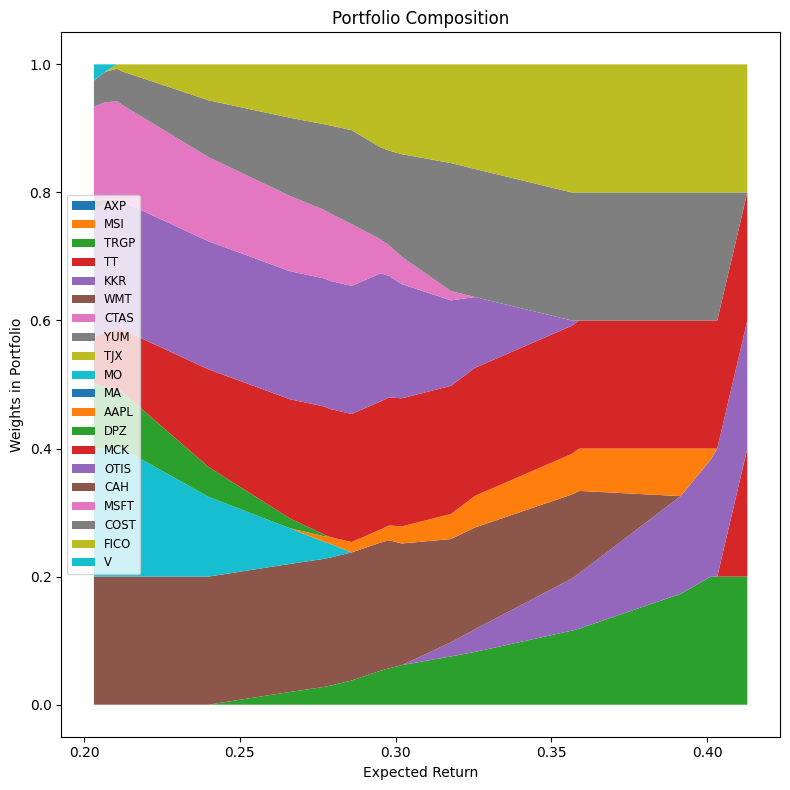

In [55]:
data = dict()
for i, ticker in enumerate(tickers):
    data[ticker] = {
        'Weight': weights_mean_variance[i],
        'Returns': returns_mean_variance[i],
    }
    
df_plot = pd.DataFrame.from_dict(
    data,
    orient='index',
    columns=['Weight', 'Returns']
).reset_index().rename(columns={'index': 'Ticker'})

weights_arr = np.array(weights_mean_variance) 
returns_arr = np.array(returns_mean_variance) 

fig, ax = plt.subplots(figsize=(8, 8))
ax.stackplot(
    returns_arr,
    weights_arr.T,              
    labels=tickers,
)

ax.set_xlabel('Expected Return')
ax.set_ylabel('Weights in Portfolio')
ax.set_title('Portfolio Composition')
ax.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

# Efficient frontier

In [56]:
def add_scatter(
    ax: plt.Axes,
    x: np.ndarray,
    y: np.ndarray,
    marker: str,
    color: str,
    label: str,
):
    size = 50
    ax.scatter(x=x, y=y, marker=marker, s=size, color=color, label=label)

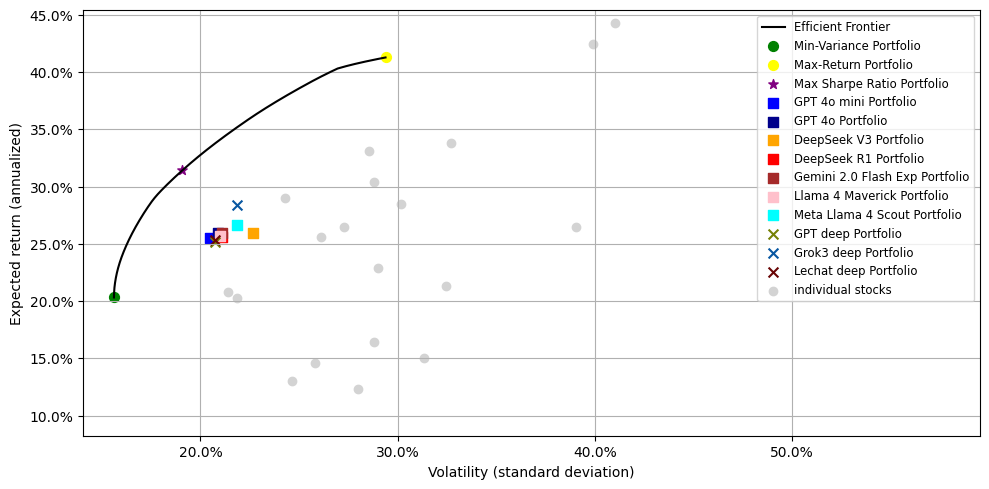

In [57]:
fig = plt.figure(figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.rcParams['figure.figsize'] = [10, 5]

ax.plot(std_mean_variance, returns_mean_variance, 'k-', label='Efficient Frontier')

add_scatter(ax, std_min_var, returns_min_var, 'o', 'green', 'Min-Variance Portfolio')
add_scatter(ax, std_max_ret, returns_max_ret, 'o', 'yellow', 'Max-Return Portfolio')

if sharpe_ratio > 0:
    add_scatter(ax, std_sharpe, returns_sharpe, '*', 'purple', 'Max Sharpe Ratio Portfolio')
    
add_scatter(ax, std_gpt_4o_mini, returns_gpt_4o_mini, 's', 'blue', 'GPT 4o mini Portfolio')
add_scatter(ax, std_gpt_4o, returns_gpt_4o, 's', 'darkblue', 'GPT 4o Portfolio')
add_scatter(ax, std_deepseek_v3, returns_deepseek_v3, 's', 'orange', 'DeepSeek V3 Portfolio')
add_scatter(ax, std_deepseek_r1, returns_deepseek_r1, 's', 'red', 'DeepSeek R1 Portfolio')
add_scatter(ax, std_gemini_2_0_flash_exp, returns_gemini_2_0_flash_exp, 's', 'brown', 'Gemini 2.0 Flash Exp Portfolio')
add_scatter(ax, std_llama_4_maverick, returns_llama_4_maverick, 's', 'pink', 'Llama 4 Maverick Portfolio')
add_scatter(ax, std_meta_llama_4_scout, returns_meta_llama_4_scout, 's', 'cyan', 'Meta Llama 4 Scout Portfolio')

add_scatter(ax, std_gpt_deep, returns_gpt_deep, 'x', "#758105", 'GPT deep Portfolio')
add_scatter(ax, std_grok3_deep, returns_grok3_deep, 'x', "#0857A1", 'Grok3 deep Portfolio')
add_scatter(ax, std_lechat_deep, returns_lechat_deep, 'x', "#690404", 'Lechat deep Portfolio')

ax.scatter(
    x=np.sqrt(np.diag(Q)), 
    y=mu, 
    color='lightgray', 
    label='individual stocks'
)

ax.axis([
    0.9 * std_list[0], 
    1.05 * np.max(np.sqrt(np.diag(Q))), 
    np.min(mu) - 0.1 * (np.max(mu) - np.min(mu)), 
    1.1 * returns_list[-1]
])

ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected return (annualized)') 
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0)) 
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.legend(loc="upper right", fontsize='small')
ax.grid()
plt.tight_layout()
plt.show()

In [58]:
weights_df['Min-Variance'] = weights_min_var
weights_df['Max-Return'] = weights_max_ret
weights_df['Max-Sharpe'] = weights_sharpe


In [59]:
weights_df.round(5)

,GPT 4o,GPT 4o mini,DeepSeek R1,DeepSeek V3,Gemini 2.0 Flash Exp,Llama 4 Maverick,Meta Llama 4 Scout,GPT deep,Grok3 deep,Lechat deep,Min-Variance,Max-Return,Max-Sharpe
AXP,0.04167,0.03571,0.04167,0.00,0.05,0.02,0.04386,0.02,0.05,0.05102,0.00000,0.0,-0.00000
MSI,0.04167,0.03571,0.04167,0.00,0.05,0.02,0.02632,0.02,0.06,0.04082,0.00000,0.0,-0.00000
TRGP,0.04167,0.03571,0.04167,0.00,0.00,0.05,0.07018,0.00,0.10,0.02041,0.00000,0.2,0.07236
TT,0.04167,0.03571,0.04167,0.05,0.00,0.01,0.06140,0.04,0.03,0.03061,0.00000,0.2,-0.00000
KKR,0.04167,0.03571,0.04167,0.00,0.05,0.01,0.03509,0.04,0.05,0.02041,-0.00000,0.2,0.01713
WMT,0.05000,0.07143,0.04167,0.00,0.05,0.01,0.05263,0.05,0.05,0.06122,0.20000,0.0,0.16769
CTAS,0.05000,0.07143,0.04167,0.00,0.05,0.06,0.01754,0.04,0.03,0.03061,0.00000,0.0,-0.00000
YUM,0.04167,0.03571,0.04167,0.00,0.05,0.03,0.04386,0.04,0.03,0.03061,-0.00000,-0.0,0.00000
TJX,0.05000,0.07143,0.04167,0.05,0.05,0.04,0.05263,0.05,0.03,0.04082,-0.00000,0.0,0.00000
MO,0.04167,0.03571,0.00000,0.00,0.00,0.04,0.02632,0.00,0.05,0.02041,0.20000,0.0,0.00000


In [60]:
stocks_returns = sp500_test_returns_df

weights = {
    "GPT 4o mini": weights_df['GPT 4o mini'],
    "GPT 4o": weights_df['GPT 4o'],
    "DeepSeek V3": weights_df['DeepSeek V3'],
    "DeepSeek R1": weights_df['DeepSeek R1'],
    "Gemini 2.0 Flash Exp": weights_df['Gemini 2.0 Flash Exp'],
    "Llama 4 Maverick": weights_df['Llama 4 Maverick'],
    "Meta Llama 4 Scout": weights_df['Meta Llama 4 Scout'],
    "GPT deep": weights_df['GPT deep'],
    "Grok3 deep": weights_df['Grok3 deep'],
    "Lechat deep": weights_df['Lechat deep'],
    "Min-Variance": weights_df['Min-Variance'],
    "Max-Return": weights_df['Max-Return'],
    "Max-Sharpe": weights_df['Max-Sharpe'],
}

cumulative_returns = pd.DataFrame(index=stocks_returns.index)
for name, weight in weights.items():
    portfolio_return = (stocks_returns * weight).sum(axis=1)
    cumulative_returns[name] = (1 + portfolio_return).cumprod()

index_names = {
    "^GSPC": "S&P 500"
}

cumulative_returns[index_names['^GSPC']] = (1 + sp500_test_df['Return']).cumprod().values
cumulative_returns.index = pd.to_datetime(cumulative_returns.index)
outsample_data = cumulative_returns.loc[test_startdate:test_enddate]

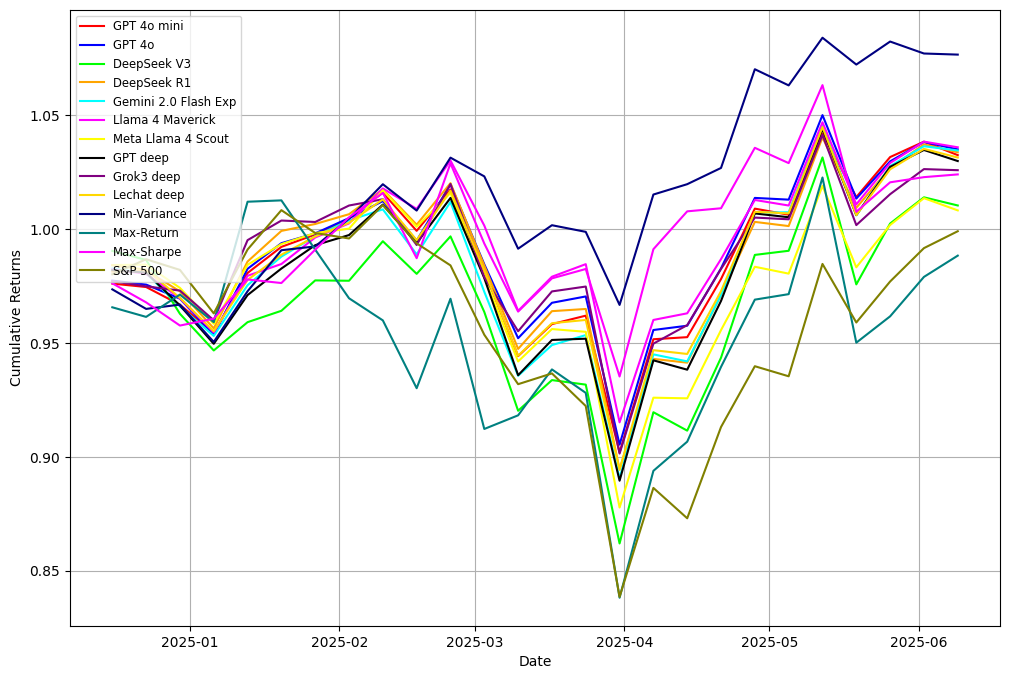

In [63]:
fig, ax = plt.subplots(figsize=(12,8))

distinct_colors = [
    'red', 'blue', 'lime', 'orange', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'gold',
    'navy', 'teal', 'fuchsia', 'olive', 'maroon', 'brown', 'pink', 'gray', 'deepskyblue', 'darkgreen'
]

for i, column in enumerate(outsample_data.columns):
    color = distinct_colors[i % len(distinct_colors)]
    ax.plot(outsample_data.index, outsample_data[column], label=column, color=color)

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.grid(True)
ax.legend(loc='upper left', fontsize='small')

plt.show()

In [64]:
fig = go.Figure()

for i, column in enumerate(outsample_data.columns):
    color = distinct_colors[i % len(distinct_colors)]
    fig.add_trace(go.Scatter(
        x=outsample_data.index,
        y=outsample_data[column],
        mode='lines',
        name=column,
        line=dict(color=color)
    ))
    
fig.update_layout(
    title = (
        f"Cumulative Returns of {len(weights)} and S&P 500 Index "
        f"from {test_startdate.strftime('%B %Y')} to {test_enddate.strftime('%B %Y')}"
    ),
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified"
)
fig.show()